# Research Example: Galaxy Morphology Classification with Deep Learning

This notebook demonstrates how to:
1. Load galaxy images from the Galaxy10 DECaLS dataset
2. Build a Random Forest baseline with hand-crafted features
3. Build a simple CNN classifier with PyTorch
4. Compare performance between traditional and deep learning approaches
5. Visualize classification results and errors

## Research Applications
- Automated galaxy classification for large surveys
- Discovering rare galaxy types
- Studying galaxy evolution through morphology
- Preparing for LSST and Euclid surveys

**Expected runtime:** ~5-10 minutes (CPU), ~2-3 minutes (GPU)

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn for baseline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler, label_binarize
print("✅ Scikit-learn available")

# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
print("✅ PyTorch available")

# Check for GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("⚠️ No GPU available, using CPU (will be slower)")

✅ Scikit-learn available
✅ PyTorch available
⚠️ No GPU available, using CPU (will be slower)


## 2. Research Motivation

### Why Galaxy Morphology Matters

Galaxy morphology reveals crucial information about:
1. **Formation history and evolution** - How galaxies form and grow
2. **Dark matter content** - Distribution of visible and dark matter
3. **Star formation rates** - Active vs quenched galaxies
4. **Environmental effects** - Impact of galaxy interactions

### Traditional Classification Challenges
- Visual classification is subjective and slow
- Billions of galaxies in upcoming surveys (LSST, Euclid)
- Need consistent, reproducible classifications

### Deep Learning Advantages
- Can process millions of galaxies quickly
- Learns complex morphological features
- Provides uncertainty estimates
- Can discover new/rare galaxy types

### Galaxy10 DECaLS Dataset
- 17,736 labeled galaxy images
- 10 morphological classes
- 256×256 pixel RGB images
- Based on Galaxy Zoo classifications

## 3. Load Galaxy10 DECaLS Dataset

In [2]:
print("Loading gz10 dataset (full training set)...")
# Load full dataset: 17,736 galaxies
gz10_data = load_dataset(
    "MultimodalUniverse/gz10",
    split="train",
    streaming=False
)

print(f"✅ Loaded {len(gz10_data)} galaxy images")

# Galaxy class names
class_names = [
    'Smooth Round',      # 0
    'Smooth In-between', # 1
    'Smooth Cigar',      # 2
    'Edge-on Disk',      # 3
    'Spiral Barred',     # 4
    'Spiral Not Barred', # 5
    'Irregular',         # 6
    'Merger',           # 7
    'Disturbed',        # 8
    'Other'             # 9
]

# Examine data structure
sample = gz10_data[0]
print(f"\nSample keys: {list(sample.keys())}")
print(f"Image type: {type(sample['rgb_image'])}")
print(f"Label: {sample['gz10_label']} ({class_names[sample['gz10_label']]})")

Loading gz10 dataset (full training set)...


gz10_rgb_images/train-00000-of-00002.par(…):   0%|          | 0.00/1.29G [00:00<?, ?B/s]

gz10_rgb_images/train-00001-of-00002.par(…):   0%|          | 0.00/1.24G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/17736 [00:00<?, ? examples/s]

✅ Loaded 17736 galaxy images

Sample keys: ['gz10_label', 'redshift', 'object_id', 'rgb_image', 'rgb_pixel_scale']
Image type: <class 'PIL.PngImagePlugin.PngImageFile'>
Label: 0 (Smooth Round)


## 4. Data Exploration and Visualization

In [3]:
# Analyze class distribution
labels = [gz10_data[i]['gz10_label'] for i in range(len(gz10_data))]
unique, counts = np.unique(labels, return_counts=True)

print("Class distribution in dataset:")
print("-" * 40)
for cls, count in zip(unique, counts):
    percentage = 100 * count / len(labels)
    print(f"{class_names[cls]:20s}: {count:4d} ({percentage:5.1f}%)")

Class distribution in dataset:
----------------------------------------
Smooth Round        : 1081 (  6.1%)
Smooth In-between   : 1853 ( 10.4%)
Smooth Cigar        : 2645 ( 14.9%)
Edge-on Disk        : 2027 ( 11.4%)
Spiral Barred       :  334 (  1.9%)
Spiral Not Barred   : 2043 ( 11.5%)
Irregular           : 1829 ( 10.3%)
Merger              : 2628 ( 14.8%)
Disturbed           : 1423 (  8.0%)
Other               : 1873 ( 10.6%)


Creating galaxy montage...
✅ Saved galaxy samples to gz10_sample_galaxies.png


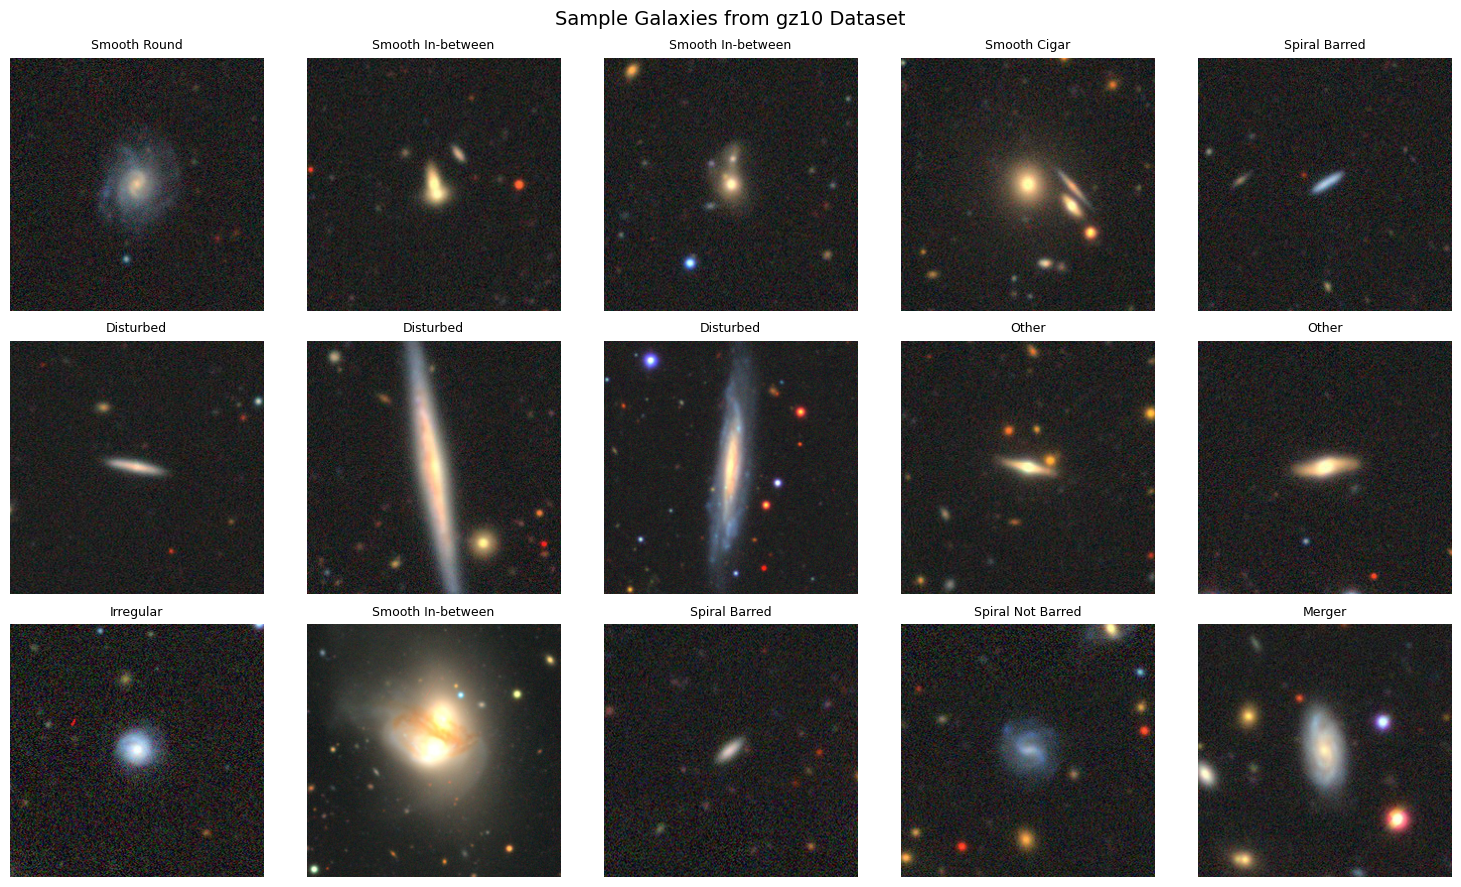

In [4]:
# Visualize sample galaxies
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

print("Creating galaxy montage...")
for i in range(15):
    img = gz10_data[i]['rgb_image']
    label = gz10_data[i]['gz10_label']
    
    # Convert PIL to numpy if needed
    if hasattr(img, 'convert'):
        img = np.array(img)
    
    axes[i].imshow(img)
    axes[i].set_title(f"{class_names[label]}", fontsize=9)
    axes[i].axis('off')

plt.suptitle('Sample Galaxies from gz10 Dataset', fontsize=14)
plt.tight_layout()
plt.savefig('gz10_sample_galaxies.png', dpi=150, bbox_inches='tight')
print("✅ Saved galaxy samples to gz10_sample_galaxies.png")
plt.show()

## 5. Prepare Data for Classification

In [5]:
# Convert images to arrays
print("Converting images to arrays...")
images = []
labels_array = []

for i in range(len(gz10_data)):
    img = gz10_data[i]['rgb_image']
    
    # Convert to numpy array
    if hasattr(img, 'convert'):
        img_array = np.array(img)
    else:
        img_array = img
    
    images.append(img_array)
    labels_array.append(gz10_data[i]['gz10_label'])

images = np.array(images)
labels_array = np.array(labels_array)

print(f"Image array shape: {images.shape}")
print(f"Labels shape: {labels_array.shape}")

# Split into train/validation sets (80/20)
n_samples = len(images)
n_train = int(0.8 * n_samples)
indices = np.random.permutation(n_samples)

train_idx = indices[:n_train]
val_idx = indices[n_train:]

X_train = images[train_idx]
y_train = labels_array[train_idx]
X_val = images[val_idx]
y_val = labels_array[val_idx]

print(f"\nTraining set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")

Converting images to arrays...
Image array shape: (17736, 256, 256, 3)
Labels shape: (17736,)

Training set: 14188 images
Validation set: 3548 images


## 6. Baseline Classification with Random Forest

Before using deep learning, let's establish a baseline using traditional machine learning with hand-crafted features:
- Color statistics (mean and std in RGB)
- Concentration (center vs outer brightness)
- Asymmetry (left-right symmetry)

In [6]:
print("Extracting simple image features...")

# Extract simple features from images
def extract_features(images):
    features = []
    for img in images:
        # Basic statistics
        mean_rgb = np.mean(img, axis=(0, 1))
        std_rgb = np.std(img, axis=(0, 1))
        
        # Central vs outer brightness
        h, w = img.shape[:2]
        center = img[h//4:3*h//4, w//4:3*w//4]
        outer = np.concatenate([
            img[:h//4, :].flatten(),
            img[3*h//4:, :].flatten(),
            img[:, :w//4].flatten(),
            img[:, 3*w//4:].flatten()
        ])
        
        center_bright = np.mean(center)
        outer_bright = np.mean(outer) if len(outer) > 0 else 0
        concentration = center_bright / (outer_bright + 1e-6)
        
        # Asymmetry (simple)
        left_half = img[:, :w//2]
        right_half = img[:, w//2:]
        asymmetry = np.mean(np.abs(left_half - np.fliplr(right_half)))
        
        # Combine features
        feat = np.concatenate([
            mean_rgb,
            std_rgb,
            [concentration, asymmetry]
        ])
        features.append(feat)
    
    return np.array(features)

# Extract features
X_train_feat = extract_features(X_train)
X_val_feat = extract_features(X_val)

print(f"Feature shape: {X_train_feat.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_val_scaled = scaler.transform(X_val_feat)

Extracting simple image features...
Feature shape: (14188, 8)


In [7]:
# Train Random Forest
print("Training Random Forest classifier...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Evaluate
rf_train_acc = rf.score(X_train_scaled, y_train) * 100
rf_val_acc = rf.score(X_val_scaled, y_val) * 100

print(f"Training Accuracy: {rf_train_acc:.2f}%")
print(f"Validation Accuracy: {rf_val_acc:.2f}%")

# Get predictions for later comparison
rf_predictions = rf.predict(X_val_scaled)
rf_pred_proba = rf.predict_proba(X_val_scaled)

# Feature importance
feature_names = ['R_mean', 'G_mean', 'B_mean',
                'R_std', 'G_std', 'B_std',
                'Concentration', 'Asymmetry']

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nFeature Importances:")
for i in range(len(feature_names)):
    print(f"  {feature_names[indices[i]]:15s}: {importances[indices[i]]:.4f}")

Training Random Forest classifier...
Training Accuracy: 99.70%
Validation Accuracy: 34.08%

Feature Importances:
  Concentration  : 0.1367
  B_std          : 0.1367
  R_std          : 0.1309
  B_mean         : 0.1238
  R_mean         : 0.1200
  G_std          : 0.1184
  Asymmetry      : 0.1176
  G_mean         : 0.1161


Creating Random Forest visualizations...
✅ Saved Random Forest performance to gz10_rf_performance.png


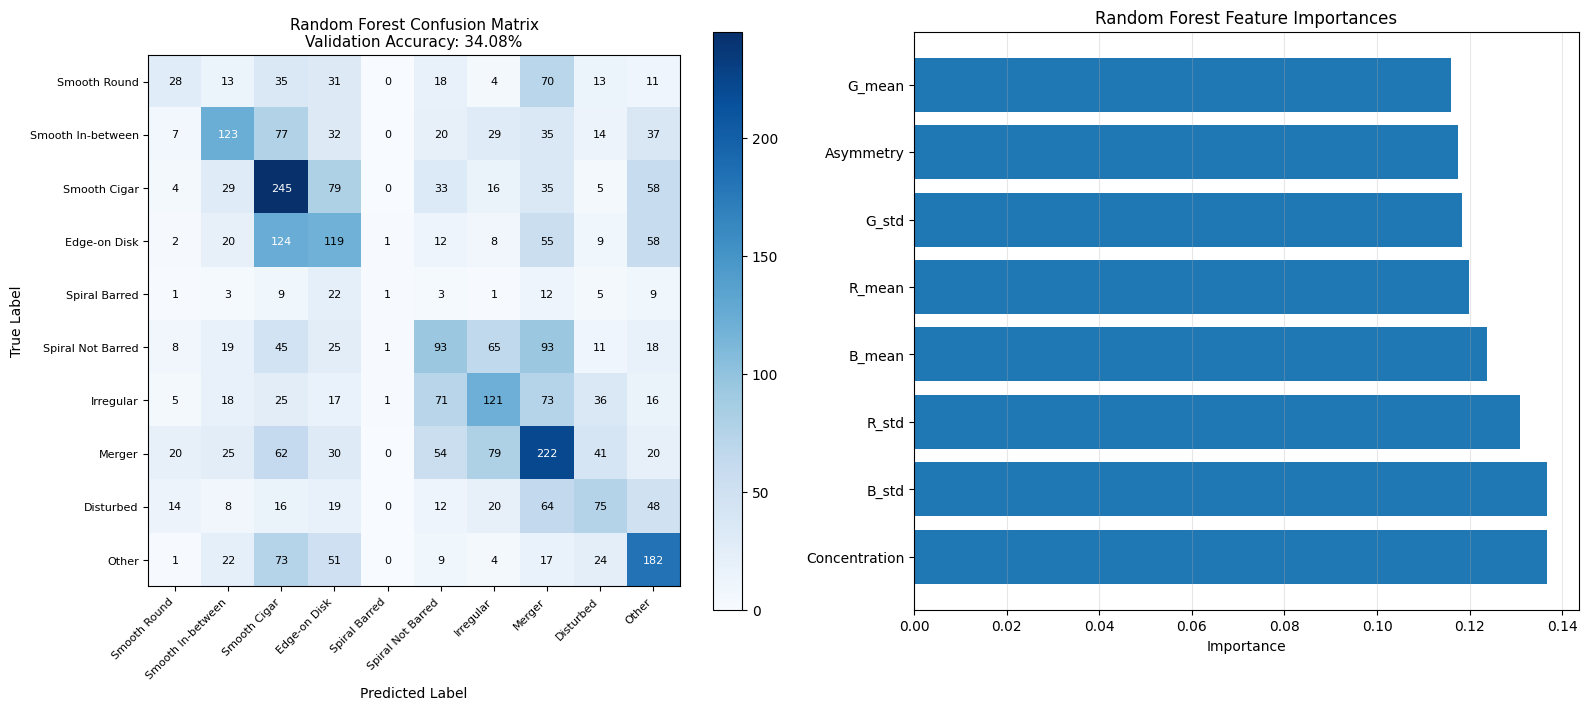

In [8]:
# Confusion matrix for Random Forest
print("Creating Random Forest visualizations...")
rf_cm = confusion_matrix(y_val, rf_predictions)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Confusion Matrix
ax = axes[0]
im = ax.imshow(rf_cm, cmap='Blues')
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(class_names, fontsize=8)

# Add text annotations
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, rf_cm[i, j],
                     ha="center", va="center",
                     color="white" if rf_cm[i, j] > rf_cm.max() / 2 else "black",
                     fontsize=8)

ax.set_xlabel('Predicted Label', fontsize=10)
ax.set_ylabel('True Label', fontsize=10)
ax.set_title(f'Random Forest Confusion Matrix\nValidation Accuracy: {rf_val_acc:.2f}%', fontsize=11)
plt.colorbar(im, ax=ax)

# Plot 2: Feature Importances
ax = axes[1]
ax.barh(range(len(feature_names)), importances[indices])
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels([feature_names[i] for i in indices])
ax.set_xlabel('Importance')
ax.set_title('Random Forest Feature Importances')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('gz10_rf_performance.png', dpi=150, bbox_inches='tight')
print("✅ Saved Random Forest performance to gz10_rf_performance.png")
plt.show()

In [9]:
# ROC curves for Random Forest (one-vs-rest)
print("Calculating ROC curves...")
y_val_bin = label_binarize(y_val, classes=range(10))

# Compute ROC curve and AUC for each class
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()

for i in range(10):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_val_bin[:, i], rf_pred_proba[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

# Compute micro-average ROC curve and AUC
fpr_rf["micro"], tpr_rf["micro"], _ = roc_curve(y_val_bin.ravel(), rf_pred_proba.ravel())
roc_auc_rf["micro"] = auc(fpr_rf["micro"], tpr_rf["micro"])

print(f"Random Forest Micro-average AUC: {roc_auc_rf['micro']:.3f}")
print("\n✅ Baseline Random Forest complete")

Calculating ROC curves...
Random Forest Micro-average AUC: 0.784

✅ Baseline Random Forest complete


## 7. Deep Learning Classification with PyTorch

Now let's build a Convolutional Neural Network (CNN) that can learn features directly from images.

In [25]:
# Custom dataset class
class GalaxyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert to PIL for transforms
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image.astype('uint8'))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = GalaxyDataset(X_train, y_train, transform=transform_train)
val_dataset = GalaxyDataset(X_val, y_val, transform=transform_val)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ Created data loaders (batch size: {batch_size})")

✅ Created data loaders (batch size: 128)


In [29]:
# Simple CNN Architecture (lightweight for fast training)
class SimpleCNN(nn.Module):
    """
    Lightweight CNN with aggressive pooling.
    
    Architecture:
    - Conv1: 3→16 channels, 3×3 MaxPool (stride 3) → 85×85×16
    - Conv2: 16→24 channels, 3×3 MaxPool (stride 3) → 28×28×24
    - Conv3: 24→32 channels, 3×3 MaxPool (stride 3) → 9×9×32
    - Flatten: 2,592 features
    - FC1: 2,592→40
    - FC2: 40→10
    
    Total parameters: ~115K
    """
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(24, 32, kernel_size=3, padding=1)
        
        # Aggressive 3×3 pooling with stride 3
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        
        # Fully connected layers
        # After 3 pools of stride 3: 256 → 85 → 28 → 9
        # Feature map size: 9×9×32 = 2,592
        self.fc1 = nn.Linear(32 * 9 * 9, 40)
        self.fc2 = nn.Linear(40, num_classes)
    
    def forward(self, x):
        # Conv block 1: 256×256×3 → 85×85×16
        x = self.pool(torch.relu(self.conv1(x)))
        # Conv block 2: 85×85×16 → 28×28×24
        x = self.pool(torch.relu(self.conv2(x)))
        # Conv block 3: 28×28×24 → 9×9×32
        x = self.pool(torch.relu(self.conv3(x)))
        
        # Flatten: 9×9×32 → 2,592
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

# Initialize model
print("Building CNN model...")
model = SimpleCNN(num_classes=10).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

Building CNN model...
Total parameters: 115,002
Trainable parameters: 115,002


In [30]:
# Training and validation functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc="Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    accuracy = 100 * correct / total
    return running_loss / len(dataloader), accuracy

def validate(model, dataloader, criterion, device, return_probs=False):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validating")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            # Get probabilities for ROC curves
            probs = torch.softmax(outputs, dim=1)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    accuracy = 100 * correct / total
    if return_probs:
        return running_loss / len(dataloader), accuracy, all_predictions, all_labels, all_probs
    return running_loss / len(dataloader), accuracy, all_predictions, all_labels

In [ ]:
# Train the model
print("Training CNN model (lightweight architecture)...")
n_epochs = 10  # Train for 20 epochs
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{n_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Training CNN model (lightweight architecture)...


Validating: 100%|██████████| 28/28 [00:36<00:00,  1.32s/it, loss=1.6874, acc=36.84%]


Epoch 1/10:
  Train Loss: 1.9295, Train Acc: 28.52%
  Val Loss: 1.7212, Val Acc: 36.84%


Training:  36%|███▌      | 40/111 [01:17<02:19,  1.96s/it, loss=1.7717, acc=39.98%]

In [ ]:
# Final evaluation
print("Final Model Evaluation")
print("-" * 40)
_, final_acc, predictions, true_labels, cnn_pred_proba = validate(
    model, val_loader, criterion, device, return_probs=True
)
predictions = np.array(predictions)
true_labels = np.array(true_labels)
cnn_pred_proba = np.array(cnn_pred_proba)
print(f"Final Validation Accuracy: {final_acc:.2f}%")

# Compute ROC curves for CNN
print("\nCalculating CNN ROC curves...")
y_val_bin_cnn = label_binarize(true_labels, classes=range(10))

fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()

for i in range(10):
    fpr_cnn[i], tpr_cnn[i], _ = roc_curve(y_val_bin_cnn[:, i], cnn_pred_proba[:, i])
    roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])

# Compute micro-average ROC curve and AUC
fpr_cnn["micro"], tpr_cnn["micro"], _ = roc_curve(y_val_bin_cnn.ravel(), cnn_pred_proba.ravel())
roc_auc_cnn["micro"] = auc(fpr_cnn["micro"], tpr_cnn["micro"])

print(f"CNN Micro-average AUC: {roc_auc_cnn['micro']:.3f}")

## 8. Visualize Training Progress

In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train')
ax1.plot(val_losses, label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(train_accs, label='Train')
ax2.plot(val_accs, label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('CNN Training History')
plt.tight_layout()
plt.savefig('gz10_training_history.png', dpi=150, bbox_inches='tight')
print("✅ Saved training history")
plt.show()

In [ ]:
# Confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, cmap='Blues')

# Add labels
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)

# Add text annotations
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, cm[i, j],
                     ha="center", va="center", color="black")

final_val_acc = 100 * np.sum(predictions == true_labels) / len(true_labels)

ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_ylabel('True Label', fontsize=11)
ax.set_title(f'CNN Confusion Matrix\nValidation Accuracy: {final_val_acc:.2f}%', fontsize=12)
plt.colorbar(im)
plt.tight_layout()
plt.savefig('gz10_confusion_matrix.png', dpi=150, bbox_inches='tight')
print("✅ Saved confusion matrix")
plt.show()

## 9. Compare Random Forest vs CNN Performance

In [ ]:
# Plot ROC curves comparison
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# Plot ROC curves for each class
for i in range(10):
    ax = axes[i]
    ax.plot(fpr_rf[i], tpr_rf[i], label=f'RF (AUC = {roc_auc_rf[i]:.2f})', linewidth=2)
    ax.plot(fpr_cnn[i], tpr_cnn[i], label=f'CNN (AUC = {roc_auc_cnn[i]:.2f})', linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{class_names[i]}', fontsize=10)
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('ROC Curves: Random Forest vs CNN (per class)', fontsize=14)
plt.tight_layout()
plt.savefig('gz10_roc_curves.png', dpi=150, bbox_inches='tight')
print("✅ Saved ROC curves")
plt.show()

In [ ]:
# Plot micro-average ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr_rf["micro"], tpr_rf["micro"],
        label=f'RF (AUC = {roc_auc_rf["micro"]:.3f})', linewidth=2, color='blue')
ax.plot(fpr_cnn["micro"], tpr_cnn["micro"],
        label=f'CNN (AUC = {roc_auc_cnn["micro"]:.3f})', linewidth=2, color='red')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Micro-Average ROC Curve: Random Forest vs CNN', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('gz10_roc_micro_average.png', dpi=150, bbox_inches='tight')
print("✅ Saved micro-average ROC curve")
plt.show()

In [ ]:
# Find misclassified samples
rf_misclassified = np.where(rf_predictions != y_val)[0]
cnn_misclassified = np.where(predictions != true_labels)[0]

print(f"Random Forest misclassifications: {len(rf_misclassified)} / {len(y_val)} ({100*len(rf_misclassified)/len(y_val):.1f}%)")
print(f"CNN misclassifications: {len(cnn_misclassified)} / {len(true_labels)} ({100*len(cnn_misclassified)/len(true_labels):.1f}%)")

# Find samples where RF was wrong but CNN was right
rf_wrong_cnn_right = [i for i in rf_misclassified if i not in cnn_misclassified]
# Find samples where CNN was wrong but RF was right
cnn_wrong_rf_right = [i for i in cnn_misclassified if i not in rf_misclassified]
# Find samples where both were wrong
both_wrong = [i for i in rf_misclassified if i in cnn_misclassified]

print(f"\nRF wrong, CNN right: {len(rf_wrong_cnn_right)}")
print(f"CNN wrong, RF right: {len(cnn_wrong_rf_right)}")
print(f"Both wrong: {len(both_wrong)}")

In [ ]:
# Visualize CNN misclassifications
if len(cnn_misclassified) > 0:
    print("Visualizing CNN misclassifications...")
    
    # Show some misclassified examples
    n_show = min(9, len(cnn_misclassified))
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(n_show):
        idx = cnn_misclassified[i]
        img = X_val[idx]
        true_label = true_labels[idx]
        pred_label = predictions[idx]
        rf_label = rf_predictions[idx]
        
        axes[i].imshow(img)
        title = f"True: {class_names[true_label]}\n"
        title += f"CNN: {class_names[pred_label]}\n"
        title += f"RF: {class_names[rf_label]}"
        axes[i].set_title(title, fontsize=8, color='red')
        axes[i].axis('off')
    
    plt.suptitle('CNN Misclassifications (with RF predictions for comparison)', fontsize=14)
    plt.tight_layout()
    plt.savefig('gz10_misclassified.png', dpi=150, bbox_inches='tight')
    print("✅ Saved misclassified examples")
    plt.show()

## 10. Summary of Results

In [ ]:
print("="*70)
print("Analysis Complete!")
print("="*70)

print(f"""
Summary of Results:
- Dataset: {len(gz10_data)} galaxies from Galaxy10 DECaLS
- Classes: 10 morphological types
- Training set: {len(X_train)} images
- Validation set: {len(X_val)} images

Random Forest Results:
- Features: Color statistics, concentration, asymmetry
- Training Accuracy: {rf_train_acc:.2f}%
- Validation Accuracy: {rf_val_acc:.2f}%
- Micro-average AUC: {roc_auc_rf['micro']:.3f}

CNN Results:
- Model: Simple CNN (~115K parameters)
- Final Validation Accuracy: {final_acc:.2f}%
- Micro-average AUC: {roc_auc_cnn['micro']:.3f}
- Training epochs: {n_epochs}

CNN Improvement over Random Forest:
- Accuracy: +{final_acc - rf_val_acc:.1f} percentage points
- AUC: +{roc_auc_cnn['micro'] - roc_auc_rf['micro']:.3f}

Generated Files:
- gz10_sample_galaxies.png
- gz10_rf_performance.png
- gz10_training_history.png
- gz10_confusion_matrix.png
- gz10_roc_curves.png
- gz10_roc_micro_average.png
- gz10_misclassified.png
""")

## 11. Project Ideas and Extensions

Ideas to extend this analysis for your research project:

### 1. Advanced Deep Learning
- Use pre-trained models (ResNet, EfficientNet) with transfer learning
- Implement attention mechanisms to highlight important features
- Try Vision Transformers (ViT) for state-of-the-art performance

### 2. Uncertainty Quantification
- Implement Bayesian neural networks
- Use dropout at test time for uncertainty estimates
- Identify galaxies the model is uncertain about

### 3. Rare Galaxy Discovery
- Use anomaly detection to find unusual galaxies
- Train on Galaxy Zoo to find rare types in gz10
- Cross-match with catalogs to verify discoveries

### 4. Morphology-Property Relations
- Cross-match with SDSS for spectra
- Study morphology vs star formation rate
- Investigate environmental effects on morphology

### 5. Domain Adaptation
- Train on gz10, apply to other surveys (HSC, Legacy Survey)
- Study how morphology classification transfers between surveys
- Prepare for LSST classification

### 6. Interpretable AI
- Use GradCAM to visualize what the network sees
- Extract learned features for scientific analysis
- Compare CNN features with traditional morphology parameters

### 7. Active Learning
- Identify galaxies that would most improve the model
- Design optimal training sets for new surveys
- Human-in-the-loop classification systems